**I. Merging all dF**

In [1]:
import pandas as pd
import numpy as np
from contextlib import contextmanager
import gc
import time


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object'
    ]
    df = pd.get_dummies(df,
                        columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('bureau.csv', nrows=num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    bureau_agg.columns = pd.Index([
        'BURO_' + e[0] + "_" + e[1].upper()
        for e in bureau_agg.columns.tolist()
    ])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index([
        'ACTIVE_' + e[0] + "_" + e[1].upper()
        for e in active_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index([
        'CLOSED_' + e[0] + "_" + e[1].upper()
        for e in closed_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    prev_agg.columns = pd.Index([
        'PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()
    ])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index([
        'APPROVED_' + e[0] + "_" + e[1].upper()
        for e in approved_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index([
        'REFUSED_' + e[0] + "_" + e[1].upper()
        for e in refused_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index([
        'INSTAL_' + e[0] + "_" + e[1].upper()
        for e in ins_agg.columns.tolist()
    ])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(
        ['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [2]:
%%time
debug = False
num_rows = 10000 if debug else None
scores = {}

df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
with timer("Save df"):
    df.to_csv('merged_df.csv.gz', compression='gzip', index=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 17s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 29s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 15s
Save df - done in 447s
Wall time: 9min 4s


**II. Load dF.gz**

In [70]:
import pandas as pd
import gc
# Pandas option to display dF efficiently
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 800)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv('merged_df.csv.gz', compression='gzip')

feats = [
    f for f in df.columns if f not in
    ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
]
train_df = df[df['TARGET'].notnull()][feats]
train_target = df[df['TARGET'].notnull()]['TARGET']
test_df = df[df['TARGET'].isnull()][feats]

del df
gc.collect()

6226

In [83]:
import re
train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
print(('Trainset shape {} Testset shape {} Target shape {}').format(
    train_df.shape, test_df.shape, train_target.shape))

Trainset shape (307507, 795) Testset shape (48744, 795) Target shape (307507,)


In [5]:
train_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
train_target.value_counts()
# It shows us an imbalanced problem

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [7]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(train_df)
display(missing_values)

Your selected dataframe has 795 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_APP_CREDIT_PERC_VAR,258350,84.0
CC_AMT_PAYMENT_CURRENT_VAR,246888,80.3
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,246814,80.3
CC_AMT_DRAWINGS_ATM_CURRENT_VAR,246814,80.3


**III. A few feature engineering**

In [10]:
import numpy as np

corr_matrix = pd.concat([train_df, train_target], axis=1).corr()
print('Correlation matrix with simple features done')

corr_matrix_log = pd.concat([train_df.add(1).apply(np.log), train_target],
                            axis=1).corr()
print('Correlation matrix with log features done')

corr_matrix_sqrt = pd.concat([train_df.add(1).apply(np.abs).apply(np.sqrt), train_target],
                             axis=1).corr()
print('Correlation matrix with square root features done')

corr_matrix_sq = pd.concat([train_df.apply(lambda x: x**2), train_target],
                           axis=1).corr()
print('Correlation matrix with squared features done')

corr_matrix_cub = pd.concat([train_df.apply(lambda x: x**3), train_target],
                            axis=1).corr()
print('Correlation matrix with cubic features done')

Correlation matrix with simple features done
Correlation matrix with log features done
Correlation matrix with square root features done
Correlation matrix with squared features done
Correlation matrix with cubic features done


In [11]:
corr = pd.concat([corr_matrix['TARGET'], corr_matrix_log['TARGET'],
                  corr_matrix_sqrt['TARGET'], corr_matrix_sq['TARGET'],
                  corr_matrix_cub['TARGET']], 
                 names=['simple ft', 'log', 'sqrt', 'squared', 'cubic'],
                 axis=1)

corr.to_csv('corr_matrix.csv')

In [12]:
corr = pd.read_csv('corr_matrix.csv')
corr.columns = ['name', 'simple ft', 'log', 'sqrt', 'squared', 'cubic']
corr.drop(index=795, inplace=True)
corr.drop(columns=['squared', 'cubic'], inplace=True)

In [14]:
display(corr.sort_values(by='log', ascending=False).head(10))
print('Best log correlated features')

display(corr.sort_values(by='sqrt', ascending=False).head(10))
print('Best sqrt correlated features')

display(corr.sort_values(by='log').head(10))
print('Best log inverse correlated features')

display(corr.sort_values(by='sqrt').head(10))
print('Best sqrt inverse correlated features')

,name,simple ft,log,sqrt
728,CC_CNT_DRAWINGS_CURRENT_VAR,0.062892,0.127765,0.103038
721,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692,0.122742,0.118708
726,CC_CNT_DRAWINGS_CURRENT_MEAN,0.082520,0.121307,0.106536
723,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,0.061123,0.114284,0.101205
725,CC_CNT_DRAWINGS_CURRENT_MAX,0.101389,0.113505,0.114335
659,CC_AMT_BALANCE_MIN,0.064163,0.101715,0.086067
709,CC_AMT_RECIVABLE_MIN,0.063610,0.097053,0.080776
714,CC_AMT_TOTAL_RECEIVABLE_MIN,0.063608,0.097053,0.080774
704,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,0.063236,0.096576,0.083905
676,CC_AMT_DRAWINGS_CURRENT_MEAN,0.058732,0.094024,0.095302


Best log correlated features


,name,simple ft,log,sqrt
721,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692,0.122742,0.118708
725,CC_CNT_DRAWINGS_CURRENT_MAX,0.101389,0.113505,0.114335
726,CC_CNT_DRAWINGS_CURRENT_MEAN,0.082520,0.121307,0.106536
728,CC_CNT_DRAWINGS_CURRENT_VAR,0.062892,0.127765,0.103038
661,CC_AMT_BALANCE_MEAN,0.087177,0.089290,0.102550
716,CC_AMT_TOTAL_RECEIVABLE_MEAN,0.086490,0.088224,0.101923
711,CC_AMT_RECIVABLE_MEAN,0.086478,0.088215,0.101910
706,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,0.086062,0.088316,0.101699
723,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,0.061123,0.114284,0.101205
676,CC_AMT_DRAWINGS_CURRENT_MEAN,0.058732,0.094024,0.095302


Best sqrt correlated features


,name,simple ft,log,sqrt
32,EXT_SOURCE_3,-0.178926,-0.183362,-0.181245
31,EXT_SOURCE_2,-0.160471,-0.162488,-0.161548
30,EXT_SOURCE_1,-0.155317,-0.159310,-0.157376
270,BURO_MONTHS_BALANCE_SIZE_MEAN,-0.080193,-0.092032,-0.088052
274,BURO_CREDIT_ACTIVE_Closed_MEAN,-0.079369,-0.078629,-0.079164
450,PREV_CODE_REJECT_REASON_XAP_MEAN,-0.073938,-0.074214,-0.074148
252,BURO_DAYS_CREDIT_UPDATE_MEAN,0.068929,-0.071429,-0.080425
314,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,0.027357,-0.070178,-0.038766
240,DAYS_EMPLOYED_PERC,-0.067952,-0.068802,-0.068423
332,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,-0.065154,-0.068585,-0.068951


Best log inverse correlated features


,name,simple ft,log,sqrt
32,EXT_SOURCE_3,-0.178926,-0.183362,-0.181245
31,EXT_SOURCE_2,-0.160471,-0.162488,-0.161548
30,EXT_SOURCE_1,-0.155317,-0.159310,-0.157376
247,BURO_DAYS_CREDIT_MEAN,0.089731,NaN,-0.097335
270,BURO_MONTHS_BALANCE_SIZE_MEAN,-0.080193,-0.092032,-0.088052
252,BURO_DAYS_CREDIT_UPDATE_MEAN,0.068929,-0.071429,-0.080425
10,DAYS_EMPLOYED,0.074957,NaN,-0.079669
274,BURO_CREDIT_ACTIVE_Closed_MEAN,-0.079369,-0.078629,-0.079164
9,DAYS_BIRTH,0.078242,NaN,-0.078564
245,BURO_DAYS_CREDIT_MIN,0.075248,NaN,-0.078482


Best sqrt inverse correlated features


In [86]:
import numpy as np

features_to_log = [
    'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
    'CC_CNT_DRAWINGS_CURRENT_VAR', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_CURRENT_MEAN'
]
train_df.loc[:, features_to_log] = train_df.loc[:, features_to_log].add(1).apply(np.log)
print('Features with log done')

Features with log done


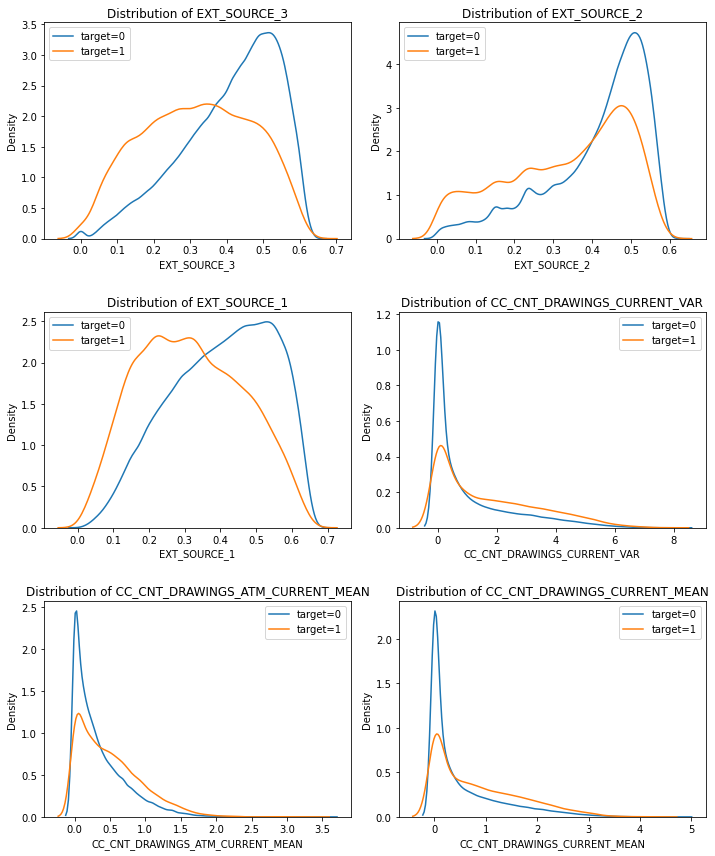

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns 


var = pd.concat([train_df, train_target], axis=1)
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(features_to_log):
    # create a new subplot for each source
    plt.subplot(3, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(var.loc[var['TARGET'] == 0, source],
                label='target=0')
    # plot loans that were not repaid
    sns.kdeplot(var.loc[var['TARGET'] == 1, source],
                label='target=1')

    # Label the plots
    plt.title('Distribution of %s' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad=2.5)

**VI. Initiate the model**

In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc
from lightgbm import LGBMClassifier

skf = StratifiedKFold(n_splits=5)
model = LGBMClassifier(nthread=4,
                       n_estimators=10000,
                       learning_rate=0.02,
                       num_leaves=34,
                       colsample_bytree=0.9497036,
                       subsample=0.8715623,
                       max_depth=8,
                       reg_alpha=0.041545473,
                       reg_lambda=0.0735294,
                       min_split_gain=0.0222415,
                       min_child_weight=39.3259775,
                       silent=-1,
                       verbose=-1)

for i, (train_idx, test_idx) in enumerate(skf.split(train_df, train_target)):
    X_train, y_train = train_df.iloc[train_idx], train_target.iloc[train_idx]
    X_test, y_test = train_df.iloc[test_idx], train_target.iloc[test_idx]

    model.fit(X_train,
              y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='auc',
              verbose=100,
              early_stopping_rounds=100)

    model.predict_proba(X_test, num_iteration=model.best_iteration_)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.775101	training's binary_logloss: 0.244887	valid_1's auc: 0.758217	valid_1's binary_logloss: 0.24871
[200]	training's auc: 0.799062	training's binary_logloss: 0.234858	valid_1's auc: 0.774465	valid_1's binary_logloss: 0.24187
[300]	training's auc: 0.812522	training's binary_logloss: 0.229102	valid_1's auc: 0.780757	valid_1's binary_logloss: 0.239191
[400]	training's auc: 0.822721	training's binary_logloss: 0.224843	valid_1's auc: 0.784528	valid_1's binary_logloss: 0.237753
[500]	training's auc: 0.831467	training's binary_logloss: 0.221294	valid_1's auc: 0.786782	valid_1's binary_logloss: 0.236933
[600]	training's auc: 0.839051	training's binary_logloss: 0.21822	valid_1's auc: 0.788168	valid_1's binary_logloss: 0.236454
[700]	training's auc: 0.845771	training's binary_logloss: 0.215404	valid

[1100]	training's auc: 0.86682	training's binary_logloss: 0.206116	valid_1's auc: 0.791388	valid_1's binary_logloss: 0.235711
[1200]	training's auc: 0.871736	training's binary_logloss: 0.203953	valid_1's auc: 0.79156	valid_1's binary_logloss: 0.235651
[1300]	training's auc: 0.876454	training's binary_logloss: 0.201801	valid_1's auc: 0.791668	valid_1's binary_logloss: 0.23562
[1400]	training's auc: 0.880951	training's binary_logloss: 0.199689	valid_1's auc: 0.791675	valid_1's binary_logloss: 0.235608
Early stopping, best iteration is:
[1362]	training's auc: 0.879228	training's binary_logloss: 0.200507	valid_1's auc: 0.791761	valid_1's binary_logloss: 0.235606
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.775526	training's binary_logloss: 0.244719	valid_1's auc: 0.760887	valid_1's binary_logloss: 0.248714
[200]	training's auc: 0.798989	t

In [ ]:
# Continue work with feature engineering

# Try SMOTE when na and infinite values are treated

# Sample the datasets to work with hyperparemeters

# Add metrics